In [1]:
import numpy as np

def bahdanau_attention(query, keys, values, Wq, Wk, v):
    """
    Additive (Bahdanau) attention in NumPy.
    Shapes:
      query:   (d_q,)             or (batch, d_q)
      keys:    (seq_len, d_k)     or (batch, seq_len, d_k)
      values:  (seq_len, d_v)     or (batch, seq_len, d_v)
      Wq:      (d_att, d_q)
      Wk:      (d_att, d_k)
      v:       (d_att,)
    Returns:
      context: (d_v,) or (batch, d_v)
      attn_weights: (seq_len,) or (batch, seq_len)
    """
    # Support batch or single example
    batched = query.ndim == 2
    if not batched:
        query = query[np.newaxis, ...]
        keys = keys[np.newaxis, ...]
        values = values[np.newaxis, ...]

    # linear projections
    # query_proj: (batch, 1, d_att)
    query_proj = np.tensordot(query, Wq.T, axes=([1], [0]))[:, np.newaxis, :]
    # keys_proj: (batch, seq_len, d_att)
    keys_proj = np.tensordot(keys, Wk.T, axes=([2], [0])) if keys.ndim == 3 else np.tensordot(keys, Wk.T, axes=([1],[0]))
    # sum, apply tanh, score with v
    score = np.tanh(query_proj + keys_proj)  # (batch, seq_len, d_att)
    # v dot score along d_att
    scores = np.tensordot(score, v, axes=([2], [0]))  # (batch, seq_len)

    # softmax
    exp = np.exp(scores - scores.max(axis=1, keepdims=True))
    attn_weights = exp / exp.sum(axis=1, keepdims=True)  # (batch, seq_len)

    # context: weighted sum over values
    context = np.einsum('bs,bsd->bd', attn_weights, values)  # (batch, d_v)

    if not batched:
        return context[0], attn_weights[0]
    return context, attn_weights

# Example usage:
seq_len, d_k, d_v, d_q, d_att = 5, 8, 16, 8, 10
query = np.random.randn(d_q)
keys = np.random.randn(seq_len, d_k)
values = np.random.randn(seq_len, d_v)
Wq = np.random.randn(d_att, d_q)
Wk = np.random.randn(d_att, d_k)
v = np.random.randn(d_att)
context, weights = bahdanau_attention(query, keys, values, Wq, Wk, v)
print("context.shape:", context.shape, "weights.shape:", weights.shape)


context.shape: (16,) weights.shape: (5,)


In [1]:
import numpy as np

def bahdanau_attention(query, keys, values, Wq, Wk, v):
    """
    Additive (Bahdanau) attention in NumPy.
    Shapes:
      query:   (d_q,)             or (batch, d_q)
      keys:    (seq_len, d_k)     or (batch, seq_len, d_k)
      values:  (seq_len, d_v)     or (batch, seq_len, d_v)
      Wq:      (d_att, d_q)
      Wk:      (d_att, d_k)
      v:       (d_att,)
    Returns:
      context: (d_v,) or (batch, d_v)
      attn_weights: (seq_len,) or (batch, seq_len)
    """
    # Support batch or single example
    batched = query.ndim == 2
    if not batched:
        query = query[np.newaxis, ...]
        keys = keys[np.newaxis, ...]
        values = values[np.newaxis, ...]

    # linear projections
    # query_proj: (batch, 1, d_att)
    query_proj = np.tensordot(query, Wq.T, axes=([1], [0]))[:, np.newaxis, :]
    # keys_proj: (batch, seq_len, d_att)
    keys_proj = np.tensordot(keys, Wk.T, axes=([2], [0])) if keys.ndim == 3 else np.tensordot(keys, Wk.T, axes=([1],[0]))
    # sum, apply tanh, score with v
    score = np.tanh(query_proj + keys_proj)  # (batch, seq_len, d_att)
    # v dot score along d_att
    scores = np.tensordot(score, v, axes=([2], [0]))  # (batch, seq_len)

    # softmax
    exp = np.exp(scores - scores.max(axis=1, keepdims=True))
    attn_weights = exp / exp.sum(axis=1, keepdims=True)  # (batch, seq_len)

    # context: weighted sum over values
    context = np.einsum('bs,bsd->bd', attn_weights, values)  # (batch, d_v)

    if not batched:
        return context[0], attn_weights[0]
    return context, attn_weights

# Example usage:
seq_len, d_k, d_v, d_q, d_att = 5, 8, 16, 8, 10
query = np.random.randn(d_q)
keys = np.random.randn(seq_len, d_k)
values = np.random.randn(seq_len, d_v)
Wq = np.random.randn(d_att, d_q)
Wk = np.random.randn(d_att, d_k)
v = np.random.randn(d_att)
context, weights = bahdanau_attention(query, keys, values, Wq, Wk, v)
print("context.shape:", context.shape, "weights.shape:", weights.shape)


context.shape: (16,) weights.shape: (5,)


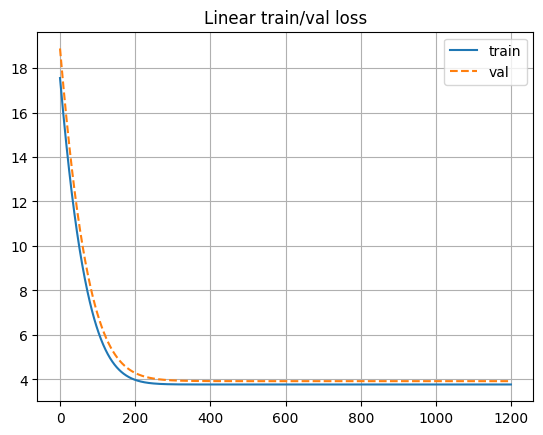

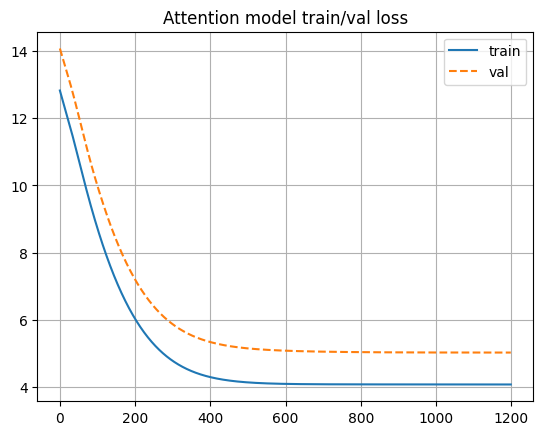

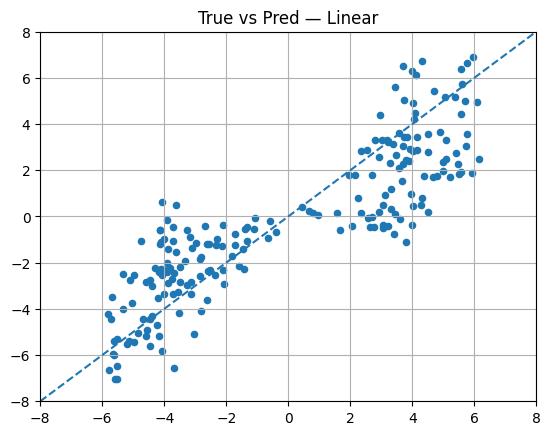

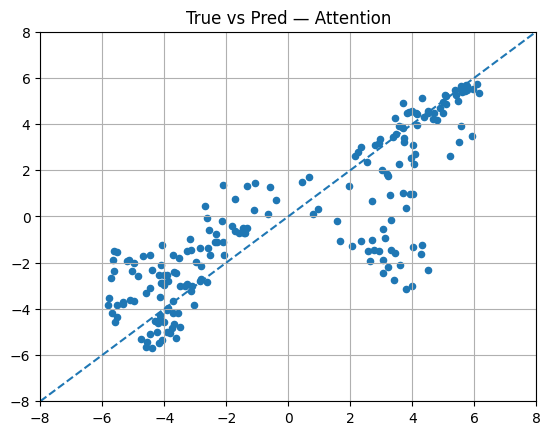

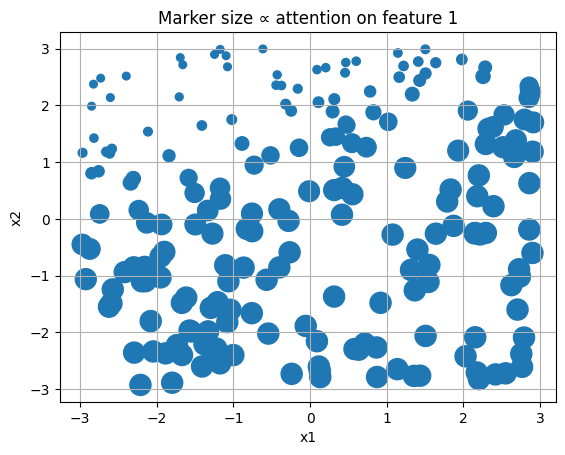

Test MSE -- Linear: 3.9195, Attention-augmented: 5.0254


In [2]:
# attention_vs_linear_demo.py
# Requires: torch, matplotlib, numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

# 1) Data
N = 800
X = np.random.uniform(-3, 3, size=(N, 2)).astype(np.float32)
y = np.where(np.abs(X[:,0]) > np.abs(X[:,1]), 2.0 * X[:,0], -1.5 * X[:,1])
y = y + np.random.normal(scale=0.3, size=y.shape)
y = y.astype(np.float32)

idx = np.arange(N); np.random.shuffle(idx)
train_idx = idx[:600]; test_idx = idx[600:]
X_train = torch.from_numpy(X[train_idx])
y_train = torch.from_numpy(y[train_idx]).unsqueeze(1)
X_test = torch.from_numpy(X[test_idx])
y_test = torch.from_numpy(y[test_idx]).unsqueeze(1)

# 2) Models
class LinearReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2,1)
    def forward(self,x):
        return self.fc(x)

class AttentionLinearReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.attn = nn.Linear(2, 2)
        self.reg = nn.Linear(2,1)
    def forward(self,x):
        logits = self.attn(x)
        a = F.softmax(logits, dim=-1)   # attention weights sum to 1
        x_tilde = a * x
        out = self.reg(x_tilde)
        return out, a, logits

model_lin = LinearReg()
model_attn = AttentionLinearReg()

# 3) Training function
def train_model(model, X_tr, y_tr, X_val, y_val, epochs=1200, lr=1e-2, attn=False):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    train_losses, val_losses = [], []
    for ep in range(epochs):
        model.train()
        opt.zero_grad()
        if attn:
            out, _, _ = model(X_tr)
        else:
            out = model(X_tr)
        loss = loss_fn(out, y_tr)
        loss.backward()
        opt.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            if attn:
                v, _, _ = model(X_val)
            else:
                v = model(X_val)
            val_losses.append(loss_fn(v, y_val).item())
    return train_losses, val_losses

train_losses_lin, val_losses_lin = train_model(model_lin, X_train, y_train, X_test, y_test, epochs=1200, lr=1e-2, attn=False)
train_losses_attn, val_losses_attn = train_model(model_attn, X_train, y_train, X_test, y_test, epochs=1200, lr=5e-3, attn=True)

# 4) Eval
model_lin.eval(); model_attn.eval()
with torch.no_grad():
    ypred_lin = model_lin(X_test).numpy().squeeze()
    ypred_attn, attn_weights, _ = model_attn(X_test)
    ypred_attn = ypred_attn.numpy().squeeze()
    attn_weights = attn_weights.numpy()
    y_true = y_test.numpy().squeeze()

# 5) Plots (separate figures)
plt.figure(); plt.plot(train_losses_lin, label='train'); plt.plot(val_losses_lin, linestyle='--', label='val'); plt.title('Linear train/val loss'); plt.legend(); plt.grid(True)
plt.figure(); plt.plot(train_losses_attn, label='train'); plt.plot(val_losses_attn, linestyle='--', label='val'); plt.title('Attention model train/val loss'); plt.legend(); plt.grid(True)
plt.figure(); plt.scatter(y_true, ypred_lin, s=20); plt.plot([-8,8],[-8,8],'--'); plt.title('True vs Pred — Linear'); plt.xlim(-8,8); plt.ylim(-8,8); plt.grid(True)
plt.figure(); plt.scatter(y_true, ypred_attn, s=20); plt.plot([-8,8],[-8,8],'--'); plt.title('True vs Pred — Attention'); plt.xlim(-8,8); plt.ylim(-8,8); plt.grid(True)
plt.figure(); x1 = X_test[:,0].numpy(); x2 = X_test[:,1].numpy(); a1 = attn_weights[:,0]; sizes = 30 + 200*(a1 - a1.min())/(a1.max()-a1.min()+1e-9); plt.scatter(x1,x2,s=sizes); plt.title('Marker size ∝ attention on feature 1'); plt.xlabel('x1'); plt.ylabel('x2'); plt.grid(True)
plt.show()

mse_lin = ((ypred_lin - y_true)**2).mean()
mse_attn = ((ypred_attn - y_true)**2).mean()
print(f"Test MSE -- Linear: {mse_lin:.4f}, Attention-augmented: {mse_attn:.4f}")


In [1]:


# EfficientNetV2-S (PyTorch)
# This file shows a practical way to create and adapt EfficientNetV2-S using torchvision's implementation.
# It includes helpers to: 1) load pretrained EfficientNetV2-S, 2) change number of input channels, 3) change classifier for custom num_classes,
# and 4) a small example of constructing the model and a sample forward pass for 320x320 input.

import torch
import torch.nn as nn
from torchvision import models, transforms


def replace_first_conv(model: nn.Module, in_channels: int) -> nn.Module:
    """Replace the first Conv2d in a torchvision model with a new Conv2d that accepts in_channels.
    This is robust to small API differences between torchvision versions (we search the module tree).
    The new conv copies weights (if possible) by repeating or averaging the pretrained weights.
    """
    # Find the first nn.Conv2d module and its parent container
    first_conv = None
    parent = None
    name_in_parent = None

    for module_name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            first_conv = module
            break

    if first_conv is None:
        raise RuntimeError("No Conv2d found in model to replace")

    # find parent module and attribute name
    for parent_name, parent_module in model.named_modules():
        for name, child in parent_module.named_children():
            if child is first_conv:
                parent = parent_module
                name_in_parent = name
                break
        if parent is not None:
            break

    assert parent is not None and name_in_parent is not None

    old_conv = first_conv
    new_conv = nn.Conv2d(
        in_channels,
        old_conv.out_channels,
        kernel_size=old_conv.kernel_size,
        stride=old_conv.stride,
        padding=old_conv.padding,
        dilation=old_conv.dilation,
        groups=old_conv.groups if old_conv.groups == 1 else 1,
        bias=(old_conv.bias is not None),
        padding_mode=old_conv.padding_mode,
    )

    # Initialize new weights by copying / averaging from old weights when possible
    with torch.no_grad():
        if in_channels == old_conv.in_channels:
            new_conv.weight.copy_(old_conv.weight)
            if old_conv.bias is not None:
                new_conv.bias.copy_(old_conv.bias)
        elif in_channels < old_conv.in_channels:
            # average contiguous channels from the pretrained conv
            new_weight = old_conv.weight[:, :in_channels, ...].clone()
            new_conv.weight.copy_(new_weight)
        else:
            # in_channels > pretrained: repeat weights across the channel dimension
            reps = int(in_channels / old_conv.in_channels)
            rem = in_channels % old_conv.in_channels
            w = old_conv.weight
            new_w = w.repeat(1, reps, 1, 1)
            if rem:
                new_w = torch.cat([new_w, w[:, :rem, :, :]], dim=1)
            new_conv.weight[:, :new_w.shape[1], ...].copy_(new_w)

        # biases (if present)
        if old_conv.bias is not None and new_conv.bias is not None:
            new_conv.bias.copy_(old_conv.bias)

    # replace in parent
    setattr(parent, name_in_parent, new_conv)
    return model


def make_efficientnet_v2_s(num_classes: int = 1000, pretrained: bool = True, in_channels: int = 3):
    """Create EfficientNetV2-S, adjust classifier and first conv for custom input channels.

    Args:
        num_classes: number of output classes.
        pretrained: whether to load ImageNet pretrained weights (if available).
        in_channels: number of input channels (default 3).

    Returns:
        model (nn.Module)
    """
    # torchvision provides efficientnet_v2_s in recent versions
    try:
        model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1 if pretrained else None)
    except Exception:
        # fallback for older torchvision versions
        model = models.efficientnet_v2_s(pretrained=pretrained)

    # Replace classifier to match num_classes
    # torchvision EfficientNetV2 usually has model.classifier as [nn.Dropout, nn.Linear]
    if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
        last_linear = None
        for m in model.classifier.modules():
            if isinstance(m, nn.Linear):
                last_linear = m
        if last_linear is not None:
            in_feats = last_linear.in_features
            new_linear = nn.Linear(in_feats, num_classes)
            # replace the final linear inside classifier sequence
            # find its index
            for idx, child in enumerate(model.classifier):
                if isinstance(child, nn.Linear):
                    classifier_list = list(model.classifier)
                    classifier_list[idx] = new_linear
                    model.classifier = nn.Sequential(*classifier_list)
                    break
    else:
        # if API differs
        if hasattr(model, 'fc'):
            in_feats = model.fc.in_features
            model.fc = nn.Linear(in_feats, num_classes)

    # Replace first conv if input channels != 3
    if in_channels != 3:
        model = replace_first_conv(model, in_channels)

    return model


if __name__ == '__main__':
    # Example usage
    num_classes = 10
    model = make_efficientnet_v2_s(num_classes=num_classes, pretrained=False, in_channels=3)
    print(model)

    # Test forward with a 320x320 image batch
    x = torch.randn(2, 3, 320, 320)
    logits = model(x)
    print('logits.shape =', logits.shape)

    # Example training preparation
    transform = transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # If you want a small training loop or finetuning recipe, ask and I will add it.


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  